In [1]:
import coffea
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
import awkward as ak
import numpy as np
from python.cms_utils import GetMuonSF
import correctionlib
import matplotlib.pyplot as plt
import hist

import mplhep as hep
hep.style.use("CMS")



In [2]:
### Define what dataset we want to use here
#dataset = 'QCD'
dataset = 'QCD'


In [3]:
prestring = "root://cmsxrootd.fnal.gov/"

In [19]:
if dataset == 'DYJets':
    file_path = prestring  + '/store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-800to1200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/2430000/4B0E9047-F0D7-AA45-A62A-45A05CDE2674.root'
else:
    file_path = prestring + '/store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_HT500to700_TuneCP5_PSWeights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v1/280000/0335FC7D-AC44-7C4B-8FF4-C9545273E7AB.root'
events = NanoEventsFactory.from_root(
    file_path, 
    treepath="Events", 
    schemaclass=NanoAODSchema
).events()

In [20]:
events_1j = events[(ak.num(events.FatJet,axis = 1)>0 ) & (ak.num(events.Muon,axis = 1)>0 )]
#events_1j = events_1j[ak.num(events_1j.Muon)>0]

In [21]:
def plot_delta_r(events_1j, **kwargs):
    fj = events_1j.FatJet
    mu = events_1j.Muon
    
    matched_mu, dr_thresh = fj.nearest(mu, threshold=None, return_metric=True)
    # ‣ For any fatjet with min‐ΔR < 0.4 to some muon, dr_thresh[i][j] is that ΔR (<0.4).
    # ‣ For any fatjet with no muon within 0.4, dr_thresh[i][j] is None.
    
    #   a) Again, fill None→999 so that “no match within 0.4” becomes dr=999:
    dr_filled2 = ak.fill_none(dr_thresh, 999.0)
    
    #   b) Keep where dr_filled2 ≥ 0.4 (i.e. either no muon in event ⇒ dr=None⇒999,
    #      or nearest muon was actually ≥0.4 away):
    keep2      = dr_filled2 >= 0.4
    
    filtered_fatjets = fj[keep2]
    
    #output = plt.hist(ak.flatten(dr_filled2), range = (0,4), bins = 100, label = 'DYJetsToLL', flow = True)

    h = hist.Hist(
            hist.axis.Regular(100, 0, 4, name="dr", label="ΔR", flow=True)
            )
    

# Fill the histogram (flatten the awkward array first)
    h.fill(dr=ak.flatten(dr_filled2), )
    h.plot(flow = 'show', **kwargs)
    plt.axvline(0.4,  color = 'red', ls = '--', )
    plt.axvline(0.8,  color = 'red', ls = '--', )

    plt.text(0.30, 12000, 'R = 0.4',color='r', rotation=90, verticalalignment='bottom', fontsize = 16)
    plt.text(0.70, 12000, 'R = 0.8',color='r', rotation=90, verticalalignment='bottom', fontsize = 16)
    hep.cms.label(rlabel = dataset)
    
    plt.xlabel(r'$\Delta R(\mu , Jet)$')
    plt.yscale('log')
    return keep2
    #plt.legend()

/opt/conda/lib/python3.10/site-packages/mplhep/plot.py:567: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


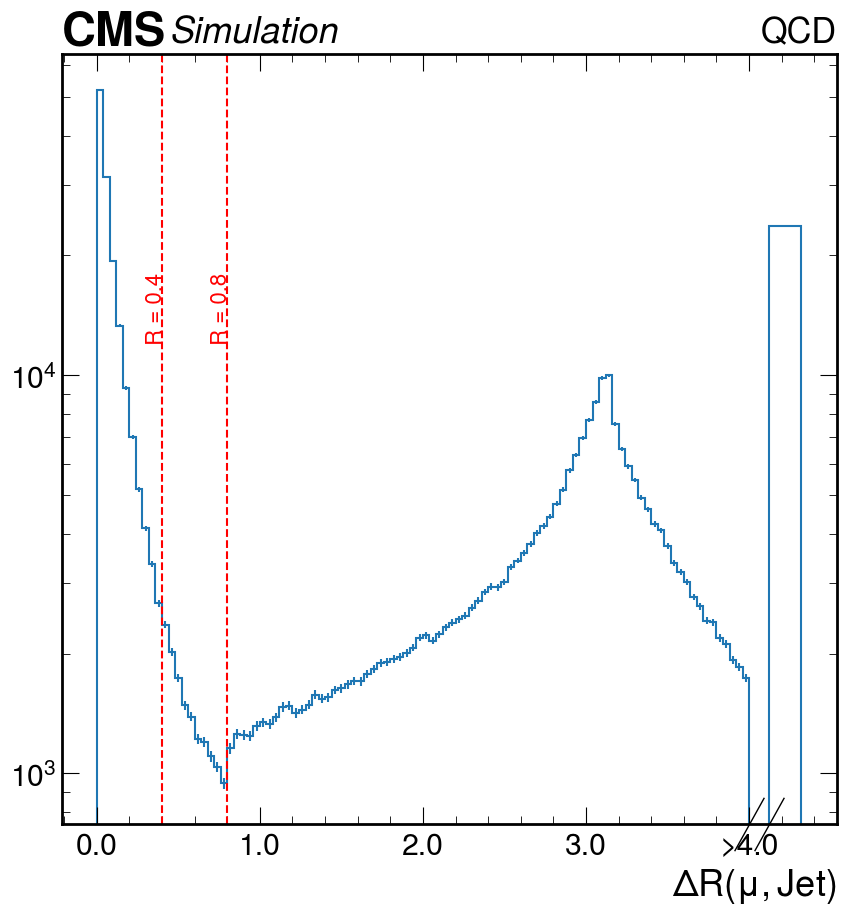

In [22]:
output = plot_delta_r(events_1j, )


In [23]:
events_filtered_muon = ak.with_field(
                events_1j,
                events_1j.Muon[(events_1j.Muon.pt > 0) 
                            &(np.abs(events_1j.Muon.eta) < 2.5)
                            &(events_1j.Muon.pfIsoId > 2) #medium iso, pfIso04 < 0.2 , 2 = loose
                            &(events_1j.Muon.mediumId	 == True)
                            #&(events0.Muon.looseId	 == True)
                
                ],
                "Muon"
            )

/opt/conda/lib/python3.10/site-packages/mplhep/plot.py:567: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


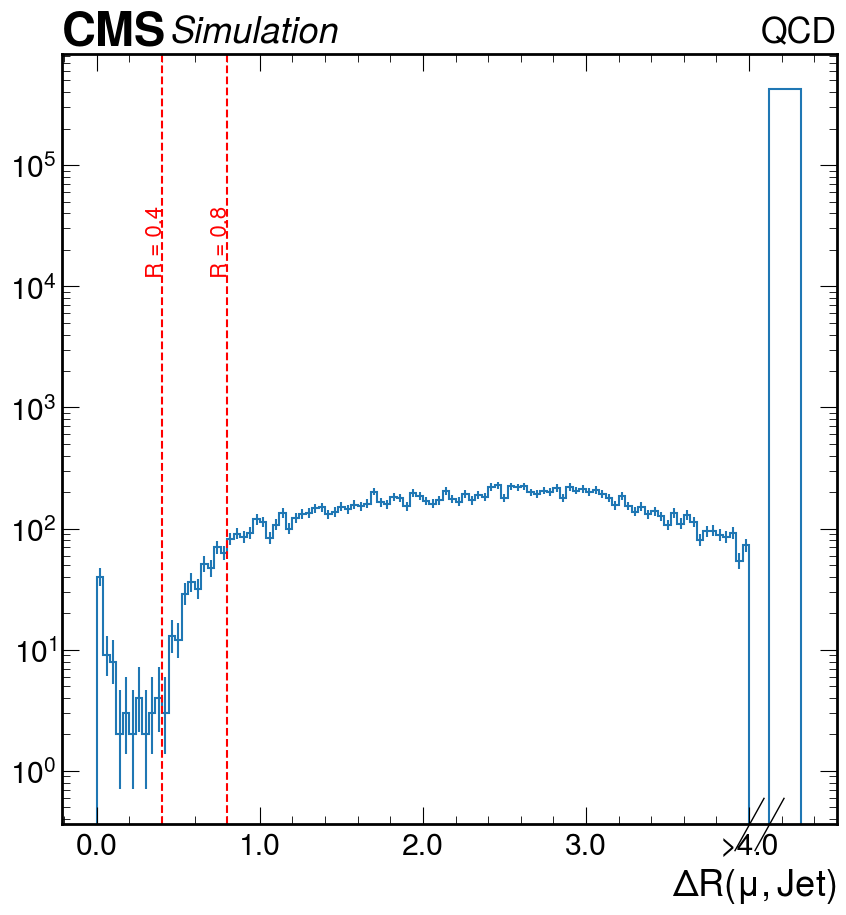

In [24]:
output = plot_delta_r(events_filtered_muon)

In [25]:
events_jetid = ak.with_field(
                events_1j,
                events_1j.FatJet[(events_1j.FatJet.jetId == 6)],
                "FatJet"
            )

/opt/conda/lib/python3.10/site-packages/mplhep/plot.py:567: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


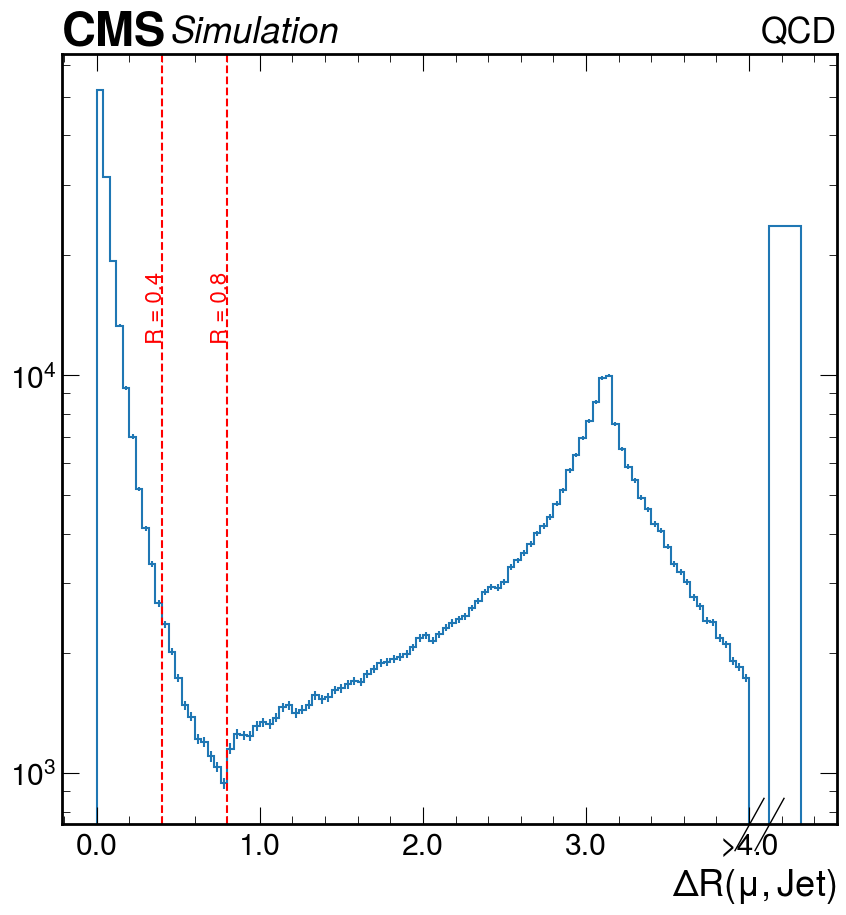

In [26]:
output = plot_delta_r(events_jetid)

/opt/conda/lib/python3.10/site-packages/mplhep/plot.py:567: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/opt/conda/lib/python3.10/site-packages/mplhep/plot.py:567: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/opt/conda/lib/python3.10/site-packages/mplhep/plot.py:567: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


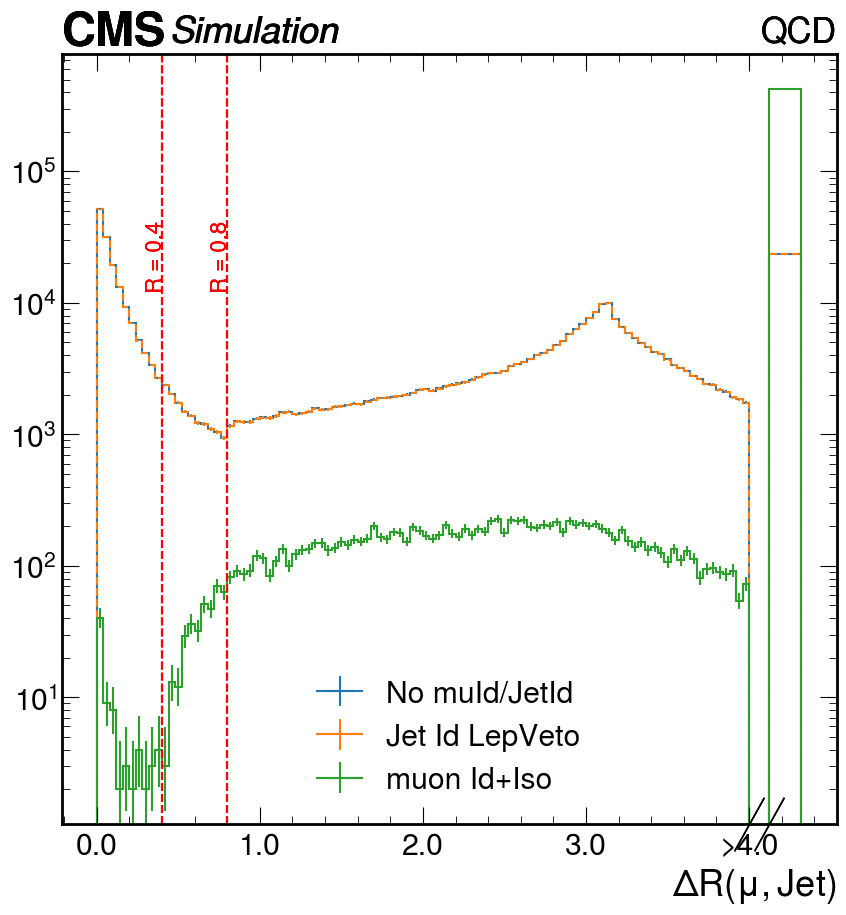

In [27]:
output1 = plot_delta_r(events_1j, label = "No muId/JetId")
output2 = plot_delta_r(events_jetid, label = "Jet Id LepVeto", ls  ='--')
output3 = plot_delta_r(events_filtered_muon, label = "muon Id+Iso")

plt.legend()
# output = plot_delta_r(events_jetid)
# output = plot_delta_r(events_filtered_muon_jetid)